# Feature Engineering Notebook

## Objectives
* 
*

## Inputs

*

## Outputs

*

## Conclusions
*

---

## Change working directory

We need to change the working directory from its current folder to its parent folder

* We access the current directory with os.getcwd()

In [72]:
import os
current_dir = os.getcwd()
current_dir

'/workspace'

We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [73]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new directory

In [74]:
current_dir = os.getcwd()
current_dir

'/'

## Load Cleaned Data

Loading the Train Set

In [75]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/datasets/cleaned/TrainSetCleaned.csv'

Loading the Test Set

In [5]:
test_set_path = "outputs/datasets/cleaned/TestSetCleaned.csv"
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,2515,0.0,4.0,No,1219,Rec,816,484,Unf,1975.0,...,32668,69.0,0.0,0,3,6,2035,1957,1975,200624
1,958,620.0,3.0,No,403,BLQ,238,240,Unf,1941.0,...,9490,79.0,0.0,0,7,6,806,1941,1950,133000
2,979,224.0,3.0,No,185,LwQ,524,352,Unf,1950.0,...,7015,69.0,161.0,0,4,5,709,1950,1950,110000


## Data Exploration
* Pandas Profiling to investigation potential transformation in our data
- Categorical/ Text data - Ordinal Encoder to transform each class into numbers.
- If Categorical but numbered classes, these do not need to be transformed (no transformation required).


In [6]:
from ydata_profiling import ProfileReport

pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation and PPS Analysis of the Cleaned Data

As we have gone through an extensive steps in the data cleaning stage, it would be useful to check the correlation and PPS levels.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df, threshold, figsize=(20,12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes, 
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True

        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True, mask=mask,
                        cmap='rocket_r',
                        annot_kws={"size": font_annot}, linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS theshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix

def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):
    
    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
         f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Then we use CalculateCorrAndPPS to calculate Correlations and Power Predictive Score

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(TrainSet)

PPS theshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.059  0.105  0.0  0.0  0.0  0.075  0.618




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



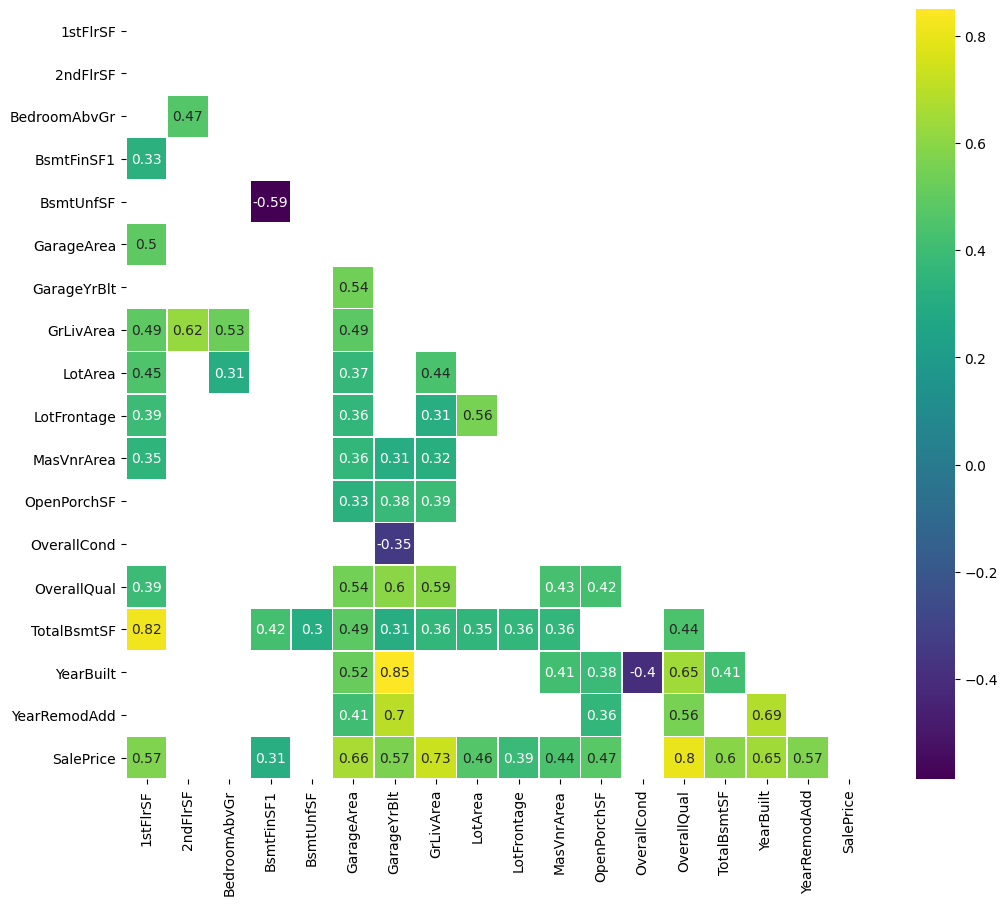



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



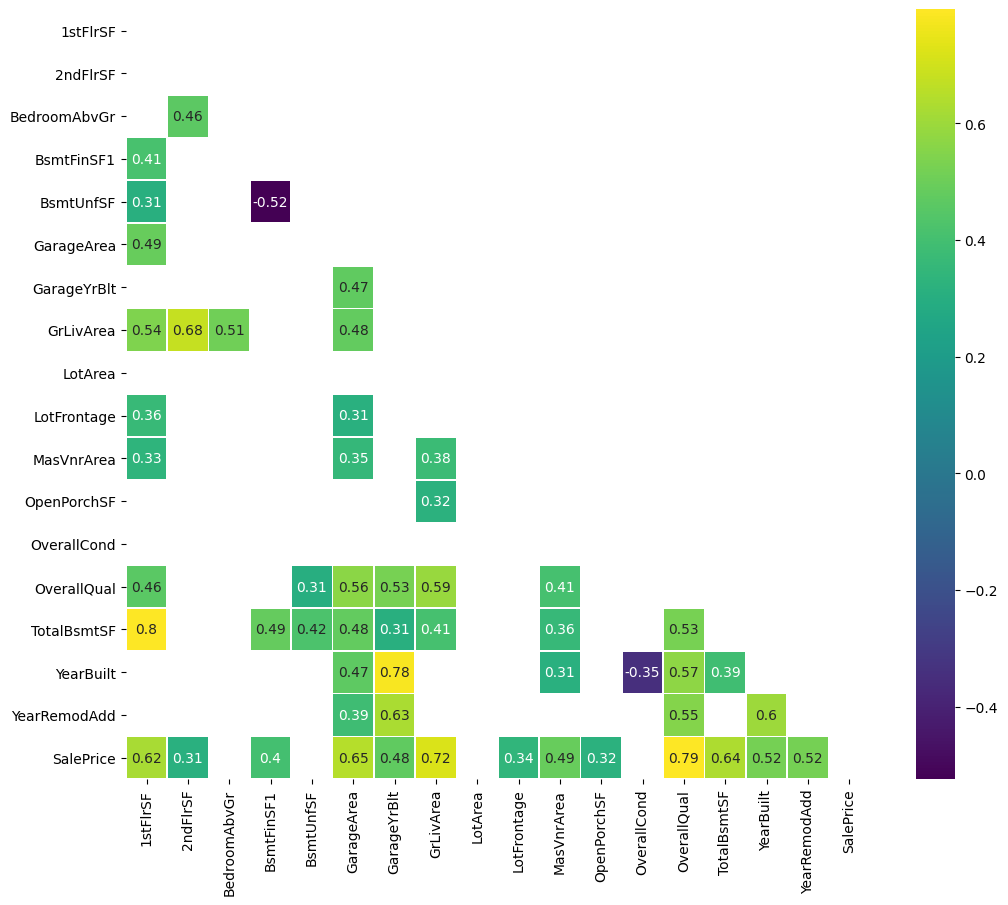



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



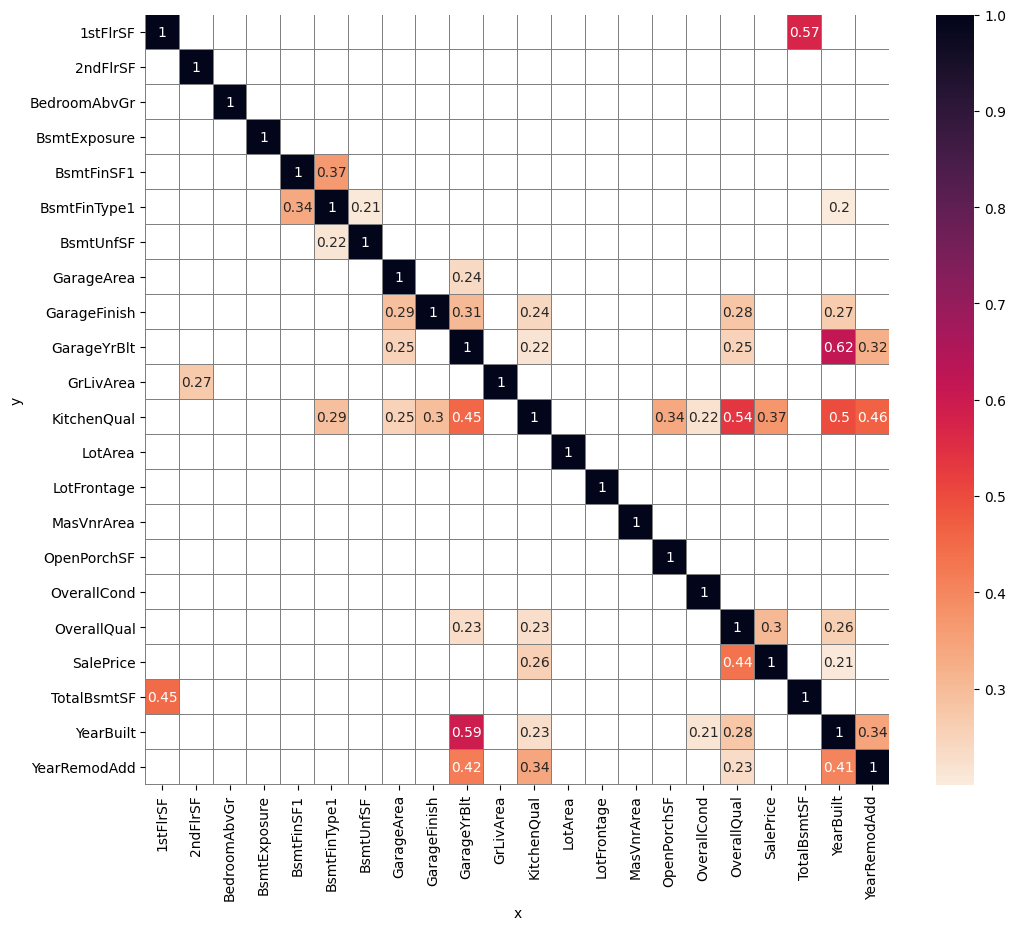

In [9]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                    df_corr_spearman = df_corr_spearman,
                    pps_matrix = pps_matrix,
                    CorrThreshold = 0.3, PPS_Threshold = 0.2,
                    figsize=(12,10), font_annot = 10)

## Feature Engineering

### Custom Function
* We will use the custom function shown in the Feature Engineering section in the CI walkthrough.
* This will allow us to assess which feature engineering techniques to use.

In [62]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - Used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distrbutions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_columns_transformers = define_list_column_transformers(analysis_type)

    # Loop over each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_columns_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

            # Apply transformers in respectives column_transformers
            df_feat_eng, list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)
            # For each variable, assess how the transformations perform
            transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)
    
        return df_feat_eng

def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    ### Check analysis type
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is missing values in your dataset. Please handle that before getting into feature engineering."
        )

def define_list_column_transformers(analysis_type):
    ### Set suffix columns according to analysis_type
    if analysis_type == 'numerical':
        list_column_transformers = ["log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']
    
    return list_column_transformers

def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')
    
    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(df_feat_eng, column)
        
    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng, column)
    
    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng, column)

    return df_feat_eng, list_applied_transformers

def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analysed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    for col in [column] + list_applied_transformers:

        if analysis_type != 'ordinal_encoder':
            DiagnosticPlots_Numerical(df_feat_eng, col)

        else:
            if col == column:
                DiagnosticPlots_Categories(df_feat_eng, col)
            else:
                DiagnosticPlots_Numerical(df_feat_eng, col)
        
        print("\n")

def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4,3))
    sns.countplot(data=df_feat_eng, x=col, palette=['#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")

def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variables, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()

def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method = 'abitrary', variables=[f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column_ordinal_encoder}")
    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)
    
    return df_feat_eng, list_methods_worked

def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    ### Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{columns}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)
    
    return df_feat_eng, list_methods_worked

def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    ### LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    ### LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    ### ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)
    
    ### PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)
    
    ### BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)
    
    ### YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)
    
    return df_feat_eng, list_methods_worked

## Feature Engineering Summary

The transformers that we will use are:
* Categorical Encoding
* Numerical Transformations
* Outlier Winsorizer
* Smart Correlation Selection

### Categorical Encoding

* Categorical Encoding - Ordinal: replaces categories by ordinal numbers

In [63]:
variables_engineering = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
variables_engineering

['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

* Create a separate DataFrame, with the variable(s)

In [66]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

,BsmtExposure,BsmtFinType1,GarageFinish,KitchenQual
0,Av,Unf,Unf,Gd
1,No,Unf,Unf,TA
2,No,ALQ,Unf,TA


* Create engineered variable(s) applying the transformation(s), assess engineered variables distribution and select most suitable method for each variable

* Variable Analysed: BsmtExposure
* Applied transformation: [] 



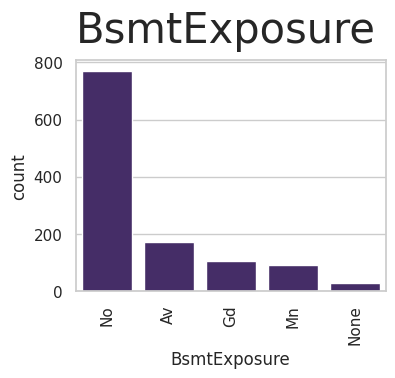

In [67]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

* Conclusion for each variable on how the transformation(s), look(s) to be effective

* For all variables, the transformation is effective, since converted categories to numbers.

## Edit

* Apply the selected transformation to the Train and Test set

In [ ]:
# the steps are:
# 1 - create transformer
# 2 - fit_transform into TrainSet
# 3 - transform into TestSet

encoder = OrdinalEncoder(encoding_method='arbitrary', variables=variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

### Numerical Transformation

* Select variable(s)

In [ ]:
variables_engineering = ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1',
                        'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea',
                         'GrLivArea', 'LotArea', 'LotFrontage',
                          'MasVnrArea', 'OpenPorchSF']

variables_engineering

* Create a separate dataframe, with the variable(s)

In [ ]:
df_engineering = TrainSet[variables_engineering].copy()
df_engineering.head(3)

* Create engineered variable(s) applying the transformation(s), assess engineered variables distribution and select most suitable method

In [ ]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

* Conclusion for each variable on how the transformation(s), look(s) to be effective

* For all variables, the transformation is effective, since converted categories to numbers.

## Edit